<a name="page-top"></a>

In [1]:
import os, sys, gc
import base64, pickle

import pandas as pd

import numpy as np
np.set_printoptions(suppress=True) #prevent numpy exponential
                                   #notation on print

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
%matplotlib inline

%reload_ext autoreload
%autoreload 2

# Add higher directory to python modules path =>
sys.path.append(os.path.realpath("..\\..\\"))

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 8.5pt;
}</style>

# French NLP model - Hyperparameters optimization

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
<p style="text-align: justify"><a href='https://keras.io/' target='_blank'><img src="../../images/tensorflow_keras_icon.png" align="right" style="margin: 0px 0px 0px 10px; width: 215px;" /></a>
In this notebook here, we employ <b><u>random search</u></b> techniques to look for optimized values for the hyperparameters of the French NLP model developped in <a href="https://github.com/aurelienmorgan/french_text_sentiment/">this parent notebook</a>. Random search consists in randomly assigning values to the hyperparameters we try to tune for model performance. For our French Reviews NLP model, we consider the RMSE as our performance metric of choice.
</p>
<br />
<p style="text-align: justify"><a href='https://github.com/dmlc/xgboost' target='_blank'><img src="../../images/xgboost_icon.png" align="right" style="margin: 0px 0px 0px 10px; width: 215px;" /></a>
The standard random search methodology will in a second time be much enhanced by relying on an XGBoost regressor to dig deeper and stumble on sets of NLP hyperparameter values that allow for the french NLP model to deliver even incomparably better performance.
<br clear="right" />
</p>
</div>
</div>

# Table of contents
1. <a href="#dataset">LOADING AND PRE-PROCESSING OF THE TRAINING DATASET</a><br />
    1.1. <a href="#embeddings">The Word Embeddings</a><br />
    1.2. <a href="#reviews">The French Reviews Dataset</a><br />
<br />
2. <a href="#search">TRAINING OPTIMIZATION - NLP HYPERPARAMETERS RANDOM SEARCH</a><br />
    2.1. <a href="#generator">Hyperparameters Random Generator</a><br />
    2.2. <a href="#training">Models Training</a><br />
<br />
3. <a href="#analysis">HYPERPARAMETERS-PERFORMANCE DISTRIBUTION ANALYSIS</a><br />
    3.1. <a href="#exploratory">Exploratory Data Analysis</a><br />
    3.2. <a href="#correlation">Hyperparameter-Performance Correlation</a><br />
    3.3. <a href="#aggregated">Aggregated View</a><br />
    3.4. <a href="#startified">Startified Analysis</a><br />
<br />
4. <a href="#xgboost">USING XGBOOST TO PREDICT THE PERFORMANCE OF AN NLP MODEL (BASED ON THE VALUES OF ITS HYPERPARAMETERS)</a><br />
    4.1. <a href="#optimization">XGBoost Regressor Optimization</a><br />
    4.2. <a href="#importance">NLP Model Hyperparameter Importance</a><br />
    4.3. <a href="#supercharging">Supercharging the NLP model optimization using our XGBoost Regressor</a><br />
<br />
5. <a href="#conclusion">CONCLUSION</a><br />


<a name="dataset"></a>
<h2>1. LOADING AND PRE-PROCESSING OF THE TRAINING DATASET <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<a name="embeddings"></a>
<h3>1.1. The Word Embeddings <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
<b>We, here, during the optimization loop, use a "light" version of the vocabulary which is made up of "only" the words we encounter at least once in our training Dataset. We do that simply to lighten the footprint of our models in memory (@see <a href="../../data/fastText_french/cc.fr.300.light.vec.html">this notebook</a> for a grasp on how we did it).</b>
<br />
<br />
Note that, for production, we would not do that since benefiting from a large vocabulary allows for our final model to "generalize" to words it had never seen during training when generating future predictions.
</p>
</div>

In [5]:
from my_NLP_RNN_fr_lib.fastText import read_fastText_vecs

word_to_index, index_to_word, word_to_vec_map = \
    read_fastText_vecs( os.path.join(os.path.realpath("..\..")
                                     , 'data', 'fastText_french', 'cc.fr.300.light.vec') )

Loaded the Vocabulary in 11.9216 seconds [129,064 word embeddings of 300 features]


<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
Adding the "<em>&lt;UKN&gt;</em>" ("unknown") token to the vocabulary for any misspelled words from the training dataset&nbsp;:
</p>
</div>

In [6]:
avg_vec = np.zeros( word_to_vec_map[ list(word_to_vec_map.keys())[0] ].shape )

for k, v in word_to_vec_map.items() :
    avg_vec += v

avg_vec /= len( word_to_vec_map )

w = "<UNK>"
word_to_vec_map[ w ] = avg_vec ; del avg_vec
word_to_index[ w ] = len( word_to_index )+1
index_to_word[ len( word_to_index ) ] = w

<a name="reviews"></a>
<h3>1.2. The French Reviews Dataset <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In [7]:
from my_NLP_RNN_fr_lib.tweet_utils import \
    load_review_fr, clean_tweet_fr, TWEET_MAX_CHAR_COUNT
from my_NLP_RNN_fr_lib.tokenizer_utils import tokenize_tweet_fr

In [8]:
# loading
reviews = load_review_fr()

Loaded the dataset in 1.4681 seconds


In [9]:
# preprocessing
reviews = clean_tweet_fr(reviews, col_name = 'comment')

In [10]:
# tokenization (as an intermediary step)
tokenized_reviews = tokenize_tweet_fr(reviews, col_name='comment')

# filtering-out lengthy elements (if any)
reviews_length_data = \
    tokenized_reviews.map( lambda sentence_tokens_list: len( sentence_tokens_list ) )
reviews.drop(
    reviews_length_data[
        (reviews_length_data > TWEET_MAX_CHAR_COUNT) | (reviews_length_data == 0)
    ].index
    , inplace=True )
reviews.reset_index(drop=True, inplace=True)
del tokenized_reviews, reviews_length_data ; dummy = gc.collect()

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
During the optimization phase, it is common practice to train model instances on small subsets of the training data. This allows for much faster iterating, while gaining valuable insights into which sets of hyperparameter values are the most promissing when latter applied to the whole dataset.
<br />
<br />
We will identify the most promissing model (the most promissing sets of NLP hyperparameter values) based on the model performance. And in order to compare apples to apples and not apples to oranges, we need to ensure that the models performances are measured against the same datasets. For that purpose, we employ seeding.
</p>
</div>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
<b>retaining only 1/20th of the data (in a reproduceable manner), for training speedup during the optimization loop =&gt;</b>
</p>
</div>

In [11]:
# sub-sampling the French Reviews dataset for faster optimization experimenting =>
import random

# set a fixed seed value so as to be able to compare on common grounds
# trained_models with different hyperparameters values
seed_state = np.random.get_state() ; np.random.seed(1234) ; random.seed(1234)

rows = random.sample(list(reviews.index), int(reviews.shape[0]/20))
reviews_20th = reviews.iloc[rows]
print("Entire French Reviews dataset : " + "{:,}".format(reviews.shape[0]) + " records - " +
      "Retained subset : " + "{:,}".format(reviews_20th.shape[0]) + " records")
reviews_20th.reset_index(drop=True, inplace=True)

Entire French Reviews dataset : 173,013 records - Retained subset : 8,650 records


In [12]:
# turning lists of word-tokens into lists of embedding matrix row indices =>
from my_NLP_RNN_fr_lib.fastText import sentences_to_indices

reviews_X = \
    sentences_to_indices(reviews_20th['comment'], word_to_index, max_len = TWEET_MAX_CHAR_COUNT)
reviews_Y = \
    reviews_20th['rating']
#del reviews ; gc.collect()

In [13]:
# extracting a validation sub-subset =>
from sklearn.model_selection import train_test_split

test_prop = .15
X_train, X_valid, y_train, y_valid = \
    train_test_split(reviews_X, reviews_Y,
                     test_size=test_prop)

In [14]:
# restore a "random" seed state
# (such as the one we were in prior to fixing it)
np.random.set_state(seed_state) ; np.random.seed(None) ; random.seed(None)

In [15]:
# data sanity check ; ensure no "rating" is malformed
assert (not reviews['rating'].isnull().any() and
        np.issubdtype(reviews['rating'].dtype, np.number)) \
    , 'we have a "rating is malformed" issue with the training data !'

<a name="search"></a>
<h2>2. TRAINING OPTIMIZATION - NLP HYPERPARAMETERS RANDOM SEARCH <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'><img src="..\..\images\tensorboard_icon.png" align="right" style="margin: 0px 0px 0px 10px;" />During hyperparameters random search, we train several instances of an NLP model. An effective way to track progress during that phase is thru Tensorboard. Tensorbard plots in (near) real time the different model metrics of our choosing. We will be tracking <u>RMSE</u> and <u>loss</u> measures on training and validation subsets.
<br clear="right" />
Monitoring models training&nbsp;:
</p>
</div>

In [19]:
from my_NLP_RNN_fr_lib.jupyter_tensorboard_windows_launcher import JupyterTensorboardWindows

log_dir = os.path.join(os.path.realpath("..\.."), "logs", "fit")

tb_launcher = JupyterTensorboardWindows( log_dir )
tb_launcher.run()

#On Windows, also view TensorBoard thru "http://localhost:6006/"
%reload_ext tensorboard.notebook
# embed a Tensorboard HTML page in an iframe in the below jupyter notebook cell (will only show when running)
%tensorboard --logdir {log_dir.replace("\\", "\\\\")}

TensorBoard 1.13.1 at http://MSI:6006 [ http://localhost:6006 ]


Reusing TensorBoard on port 6006 (pid 15168), started 0 days, 00:23:47 ago. (Use '!kill 15168' to kill it.)

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<a name="generator"></a>
<h3>2.1. Hyperparameters Random Generator <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In [16]:
from my_NLP_RNN_fr_lib.display_helper import format_vertical_headers
from my_NLP_RNN_fr_lib.model.hyperparameters import get_new_hyperparameters

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
We perform hyperparameter optimization thru <b>random value search</b> using <u>logaritmic</u> or <u>truncated normal</u> distribution as best fits. For details on how this has been implmented, refer to the <small><b><em>my_NLP_RNN_fr_lib.model.hyperparameters</em></b></small> module <a href='..\..\my_NLP_RNN_fr_lib\model\hyperparameters.py' target='_blank'><img href='.' src='../../images/target_blank.png' style='vertical-align: baseline; display: inline;' /></a>. It has been designed for the NLP model architecture we employ.
<br />
<br />
Below is an example of {{examples_count = 2 ; examples_count}} such randomly-generated sets of NLP hyperparameters values&nbsp;:
</p>
</div>

In [15]:
hyperparameters = get_new_hyperparameters(models_count = examples_count, verbose = 0)
hyperparameters.insert(loc=0, column='is_random_set', value=[1]*hyperparameters.shape[0])

format_vertical_headers(
    hyperparameters.drop(['is_random_set'], axis = 1)
    .reset_index(level=0).rename(columns = {'index':'model instance'})
)

<!DOCTYPE html> 
 
 
 
 
 
 model instance 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 lr_decay_rate 
 lr_decay_step 
 
 
 
 
 0 
 0.86 
 113 
 0.00529 
 0.03808 
 0.01647 
 18 
 3 
 5 
 31 
 3 
 0.61 
 0.0188 
 0.60 
 25 
 
 
 1 
 0.29 
 60 
 0.00546 
 0.02729 
 0.00885 
 27 
 7 
 2 
 72 
 43 
 0.59 
 0.0034 
 0.56 
 34

<a name="training"></a>
<h3>2.2. Models Training <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In [17]:
from my_NLP_RNN_fr_lib.model.training import train_models
from my_NLP_RNN_fr_lib.model.plot import plot_trained_models_history

Using TensorFlow backend.


<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<p style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
The routine in charge of the training of the model instances has been designed so that the training can take place sequentially, in waves.
<br />
<br />
Each wave can consist of any number of model instances and, all the results are maintained in a global csv file listing hyperparameter values and resulting model performance measures. All the model instances training history and model weights are also stored locally for latter re-use if needed (for instance for purposes such as cross-instance analyses).
<br />
<br />
Below, we can see the trace of the training for our wave of {{examples_count}} above-generated sets of hyperparameter values&nbsp;:
</p>
</div>

In [18]:
csv_full_path = os.path.join(os.path.realpath(".."), 'trained_instances.csv')
save_root = os.path.join(os.path.realpath(".."), 'trained_instances')
batch_size = 512 ; epochs = 120

In [33]:
train_models(hyperparameters
             , (X_train, X_valid, y_train, y_valid)
             , word_to_vec_map, word_to_index

             , csv_full_path, save_root
             , batch_size = batch_size, epochs = epochs
             , verbose = 1
)

Built the model in 4.7124 seconds
2020xxxx-110559


epoch 0 ; lr: 0.018800
epoch 25 ; lr: 0.011280
epoch 50 ; lr: 0.006768
epoch 75 ; lr: 0.004061
epoch 100 ; lr: 0.002436

model #1/2 trained (00:31:48 [+00:31:48]).

Built the model in 1.9170 seconds
2020xxxx-113747


epoch 0 ; lr: 0.003400
epoch 34 ; lr: 0.001904
epoch 68 ; lr: 0.001066
epoch 102 ; lr: 0.000597

model #2/2 trained (01:02:02 [+00:30:14]).

Trained this set of #2 models in 01:02:02.


<div style="width: 745px;"><img alt="train models widgets" src="../../images/train_models_widgets.png?uncache=4648" /></div>

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
As expected, the trained models have varying performance depending on their hyperparameter values. All this data can be retrieved from the <a href='..\..\model\trained_instances.csv' target=''>trained_instances.csv</a> file.
</div>
<br />
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
Below, for example, we can view the training history by plotting the curves for the RMSE and loss as measured on the validation dataset for our top {{best_models_count = 3 ; best_models_count}} best performing instances of our NLP model&nbsp;:
</div>
</div>

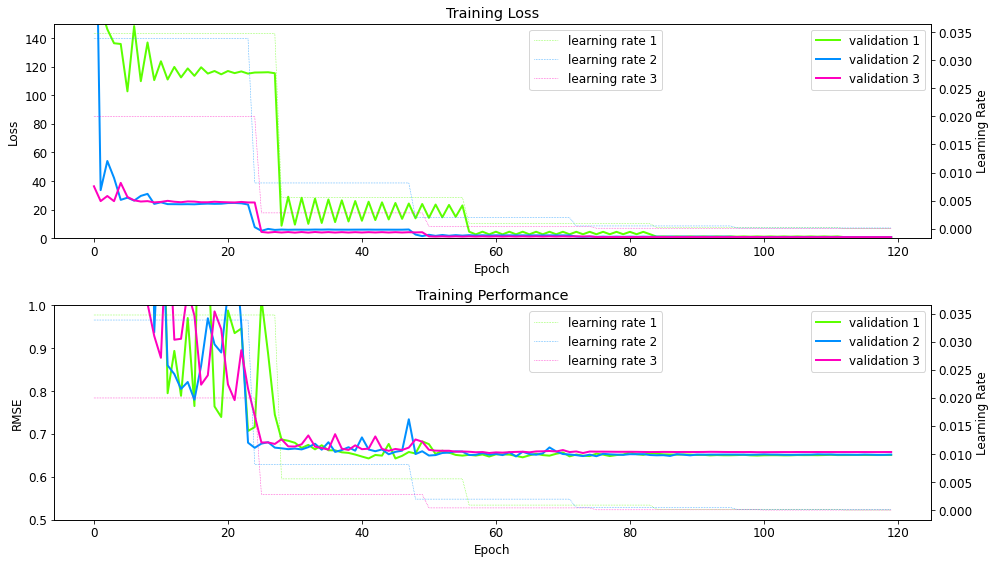

In [20]:
trained_models_df = pd.read_csv(csv_full_path)

# keep only models trained on dataset of same size (the same dataset, since we seeded it)
trained_models_df = \
    trained_models_df[(trained_models_df[ "training records" ] == X_train.shape[0]) &
                      (trained_models_df[ "validation records" ] == X_valid.shape[0]) &
                      (trained_models_df[ "batch_size" ] == batch_size) &
                      (trained_models_df[ "epochs" ] == epochs)
                     ]
trained_models_df = \
    trained_models_df.sort_values(by=["val_rmse__last_10_avg"]
                                  , ascending=True)
trained_models_df.insert(0, 'csv_idx', trained_models_df.index+1)
trained_models_df.reset_index(drop=True, inplace=True)
trained_models_df.index+=1

trained_models_rndm_df = \
    trained_models_df[(trained_models_df[ "is_random_set" ] == True)].reset_index(drop=True)
trained_models_rndm_df.index+=1
#print(str(trained_models_rnd_df.shape[0]) + " trained models in total")
plot_trained_models_history(
    trained_models_rndm_df.head(best_models_count), validation_only = True)

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
We can also have a look at the sets of hyperparameter values that brought to these respective {{best_models_count}} performances in the below table extracted from the global CSV file&nbsp;:
</div>
</div>

In [24]:
import matplotlib.colors as colors
cmap = colors.LinearSegmentedColormap.from_list("gyr", ["green","yellow","red"])

format_vertical_headers(
    trained_models_rndm_df.head(best_models_count) \
        .drop(['timestamp', 'is_random_set'
               , 'training records', 'validation records'
               , 'best_training_step', 'best_val_rmse', 'val_loss'
               , 'batch_size', 'epochs', 'local_path'], axis=1)
        .reset_index(level=0).rename(columns = {'index':'trained model rank'}) \
    .style.background_gradient(cmap=cmap, subset=['val_rmse__last_10_avg']) \
    .background_gradient(cmap=cmap, subset=['val_loss__last_10_avg'])
    , greyed_out_colnames = [ 'trained model rank', 'csv_idx', 'val_rmse__last_10_avg', 'val_loss__last_10_avg'
                              , 'train_rmse__last_10_avg', 'train_loss__last_10_avg' ]
)

<!DOCTYPE html> 
 
 
 trained model rank 
 csv_idx 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 lr_decay_rate 
 lr_decay_step 
 val_rmse__last_10_avg 
 val_loss__last_10_avg 
 train_rmse__last_10_avg 
 train_loss__last_10_avg 
 
 
 1 
 116 
 0.65 
 115 
 0.04136 
 0.00843 
 0.00356 
 25 
 3 
 2 
 49 
 42 
 0.22 
 0.0348 
 0.16 
 28 
 0.650973 
 0.896158 
 0.537944 
 0.6181 
 
 
 2 
 83 
 0.63 
 93 
 0.01227 
 0.03846 
 0.00405 
 26 
 2 
 3 
 40 
 30 
 0.18 
 0.0339 
 0.24 
 24 
 0.651747 
 0.855751 
 0.509076 
 0.483266 
 
 
 3 
 81 
 0.71 
 124 
 0.01295 
 0.00598 
 0.00534 
 28 
 2 
 5 
 48 
 35 
 0.11 
 0.02 
 0.14 
 25 
 0.657925 
 0.794618 
 0.581551 
 0.561812

<div style="text-align: justify; color: darkgray;">
    <u>NOTE&nbsp;</u>: <b>'val_rmse__last_10_avg'</b> stands for RMSE on the <u>val</u>idation dataset, average value over the last 10 training epochs.
</div>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
By relying on random search for our hyperparameters optimization, we did indeed identify some sets of values that did show better performance than others. But, can we identify levers for even better, more targetted, hyperparameters values search in order to further enhance our results&nbsp;?
<br />
<br />
Let's see what the collection of trained NLP model instances we gathered can teach us in the next chapter.
</div>
</div>

<a name="analysis"></a>
<h2>3. HYPERPARAMETERS-PERFORMANCE DISTRIBUTION ANALYSIS <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<a name="exploratory"></a>
<h3>3.1. Exploratory Data Analysis <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
With several trained instances of our NLP model architecture in hand, we logically could try to identify patterns to see which hyperparameter has the biggest deterministic power when it comes to model performance. Let us look into the possible existence of univariate correlation. For that purpose, first, we can draw hyperparameter-to-performance scatter plots&nbsp; :
</div>
</div>

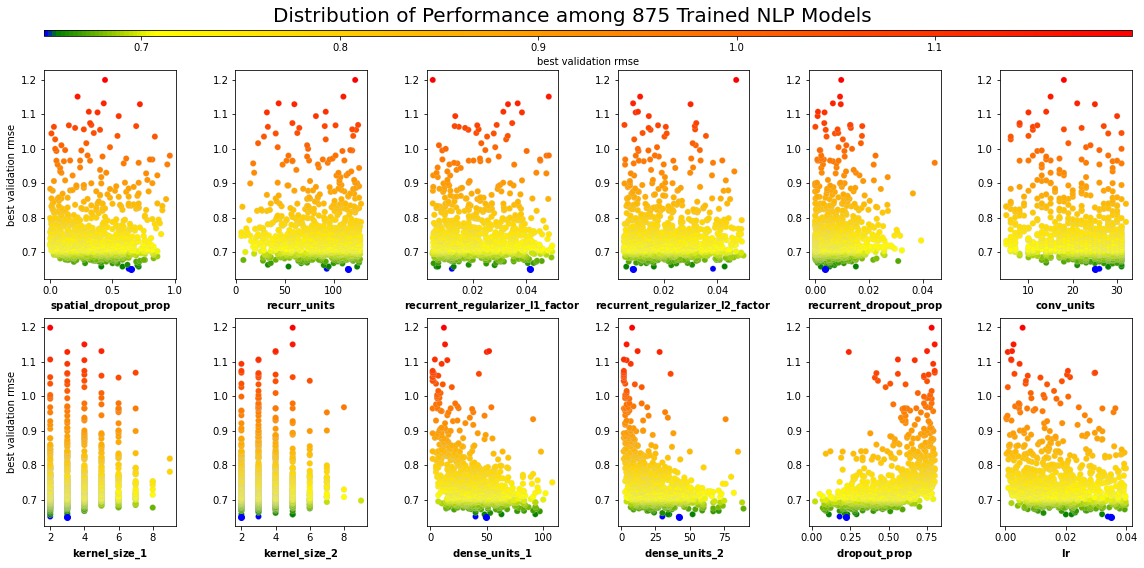

In [25]:
from my_NLP_RNN_fr_lib.model.plot import hyperparameters_univariate_rmse_plot

hyperparameters_univariate_rmse_fig = hyperparameters_univariate_rmse_plot(
    trained_models_rndm_df, col_name = 'val_rmse__last_10_avg'
    # to preserve plots scaling, exclude \"extreme outliers\" from plots =>
    , outliers_threshold = 1.2
)

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
Our intuition from the above chart is that there may be more than one local minima to the the optimum set of NLP hyperparameters.
<br />
<br />
We can see on the above figure that it is quite hard to find any monothonic relationship between one hyperparameter and the performance of the NLP models. From observation, to the naked eye, the one hyperparameter which seems to have potential for such a relationship would be '<b>dropout_prop</b>'. Lets however have a closer look by investigating the correlation matrix for our collection of trained NLP models&nbsp;:
</div>
</div>

<a name="correlation"></a>
<h3>3.2. Hyperparameter-Performance Correlation <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In [21]:
from my_NLP_RNN_fr_lib.display_helper import two_columns_display

# correlation matrix
performance_correlation_matrix = \
    trained_models_rndm_df.drop(['timestamp', 'csv_idx', 'is_random_set', 'training records', 'validation records'
                                 , 'best_training_step', 'best_val_rmse', 'val_loss'
                                 , 'val_loss__last_10_avg', 'train_rmse__last_10_avg', 'train_loss__last_10_avg'
                                 , 'batch_size', 'epochs', 'local_path'], axis=1).corr()
# only keepling half
arr = np.triu(performance_correlation_matrix, k=0) ; arr[arr == 0] = np.nan

# plotting
fontsize = 13 ; plt.ioff() ; fig = plt.figure(figsize=(4, 5)) ; ax = plt.gca()
htmp = ax.matshow(arr.astype('float'))
ax.set_xticks(range(performance_correlation_matrix.shape[1]), minor=False)
ax.set_xticklabels(performance_correlation_matrix.columns, fontsize=fontsize, rotation=45, ha="left")
ax.set_yticks(range(performance_correlation_matrix.shape[1]), minor=False)
ax.set_yticklabels(performance_correlation_matrix.columns, fontsize=fontsize)
cb = fig.colorbar(htmp, orientation='horizontal') ; cb.ax.tick_params(labelsize=fontsize)
ax.text(.5,.05,'Correlation Matrix',  horizontalalignment='center', transform=ax.transAxes, fontsize=14)
#plt.show()

if not os.path.isdir(os.path.join('..', '..', 'tmp')) : os.makedirs(os.path.join('..', '..', 'tmp'))
title = "hyperparameters_correlation"
fig_url = os.path.join('..', '..', 'tmp', title+".jpg")
plt.savefig(fig_url, bbox_inches='tight') ; plt.close(fig)

# use base64 encoding to circumvent image (external file) caching (webbrowser)
with open(fig_url, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
encoded_string = "data:image/jpeg;charset=utf-8;base64, " + encoded_string.decode()
os.remove(fig_url)

# absolute_performance_correlation
absolute_performance_correlation = \
    pd.DataFrame(abs(performance_correlation_matrix['val_rmse__last_10_avg']).iloc[:-1].sort_values(ascending=False)
                ).rename(columns={'val_rmse__last_10_avg': 'absolute performance correlation coeff.'})
hyperparameter = absolute_performance_correlation.iloc[0].name

two_columns_display('<img src="' + encoded_string + '" />', absolute_performance_correlation.to_html(), .55)

<!DOCTYPE html>
 
 

 
 

 

 
 
 
 <img src="data:image/jpeg;charset=utf-8;base64, /9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAGyAggDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKK8U+MP7Y+h/Dv9rb4Zfsc6FpUN14p8fLeajP8A2t9stLeHR7W2nknltbhbWSC6vFkjiH2QyRsI5GlJCqN3tTMFUvngDNAC0V4p+xd+2Nof7aWneOPHPgTSoIfC3hzxvceHNFuZ/tkGo3E1rBAbv7bZXVtC9jIk8josZLl41SQld4Ue10AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUEgDJNAAelfHfxt/4KO6J8dvgP8AGrwh+wReeJ9U+I/w60G4/thovCVzBLoVyl61tJCBeQbDfmGK5uYIGRwypFI6iORN/ef8FHf2kNW+CH7MWueKPhx8SLbQbu28QaLpXifxXa2sN9J4N02+v4re61eSBzsU28Dyyq0wMasgd1dUZD43qfwa/Z68YftBHxN/wT7/AGvrPwT8UNG8Hi6+I3j3RdFs9c0nWtPuZZEifXfLeK2m1FpBNcQSOwmBhdiGiLK4B87/ABO+Jf7Gni7URZ6t+218RfG/wVj8MLrup+P9Rvr3VNb+C/i9NUgtdM1GPUhbM2lys0t8JIZn2oljJvi8otu9w/aI/aZ8OfEXxh8Idc+K/wC0t8UPhX8DvGfw7lu/D/xBguD4ZudQ8Rm8hjtZNVkEEZtUmtsTQwkQxSNcsJIgRGq9X4t+I3wpv/2tv+GVP2qv2gNLj+GmgfCHStY0rTPHa6Wtn8TZ55po7vUr65nRYbv7MLe2byYEjjEl4ZWz+5WPoP2B/wBnG90fRtA+IHwL/am8U3X7Plx9q1XwB8MNb8LRxSJDOGjhT7bcbrh9KUbrm1twkZHmxN5jRKkVAGX/AMEyPgHqPiiz0r9ujX/HfiCDxP4hsdT0XxFeWdqtlYfE7Sra/kh0PxDqNnNbIwuzZRJJHcRrA7x3PzF4igr7NoAA6CigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKZLPDCUWSVVaRtsas2C5wTgepwCfoDQA+vhv9rH9qP45/s0/8FGdG0DxtDrNp8J/iJ4a0vQtO+IN3eXNv4e8EXbyah9oMojtGhn1O7mSxigM0u2NVGTGH2z+p/BT/gpL4H+J/wC0Zffs7+PfhH4q+Hs+qXl2vwp1zxhbxwWvxAtrMmO8kscMTFNHIkrC1m2zvbhLhVKmRYtX/gpP8fPgZ8A/2QvFviX49fD+y8YeH9RhGjXXhfUZY4rO/luF+WO7nlBjtIFXMsk78xohZFeTYjAHwvcfsBfGjS/24E8Ofsk+CPEnw51bwm0el2nxMvPBFveeHvF3hybT0u9XvvEl9LMJvEd9qOoTRwJCSxtTC0yoCJnMX7LG74z/ALFHin9nvx7+yqtj8QfgXZyeIYvgR4jtJVuPiXrA0svFreq6c1tZpdWU1+zyW9ogK/6LEpEbJHHF9a/8Ejf2i/EHxU+Cd38D/Gf7Peu/DjUvhnaaZa2Gla/4gu9UmvtGu7XztPvXnvY47kSyRq++KdRJGVAcKxaOOL/goX+0T/wTq/Zr+PXwd+JH7UerfZPiJaa06+C7nRr5oLuz02UGG8utQZJYx/ZEPmLLIJyYzJFHsV5AFoA82/4JU/sJat4e8J+IrT4w+Er7VfhI+qC58A/D34yfDTT4NR0zVmVJNT1Wxt1kZNI0+5u2n8nTRCnlrEsibUceZ+gKqqjCjFU/DniPw/4v0Gz8U+FdatdR03ULdZ7G/sp1liniYZV0dSQwI7irtABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRTZpobeJp7iVURFLO7tgKByST2FfEv7bn7XOqv+0j4B+B11+0Nq3we+EfinR9RkX48eE9Q0ea21DxAg2QaE11ex3EOnsqNJc5eLM5iRFdQkoIB9uUV4F/wTk+OPxP+O3wH1TVPit4p07xPe+G/HeteHLLx3o1mILLxbaWVyYY9UhRAIwHIaNhEWiEkMgRmAzXvtAB0615R+19+yn4d/aw+HNr4cufE+o+HfEXh/U01fwT4t0ecx3Wh6pGrLFcx4OG4ZlZTkMjsO9ed/tj/t7/AAo8Baf4o+AHw++PNr4V+JBS10fT/E+o+DtQ1PQ/Dutagp/s+31C6t4zb2082VMcM0qsfNiYqRIgbO/4J8/tHeB/Av7I+o+Afjdp934D8TfAzRxF8YbbxJfz3CWs4ikuZ9WF7OWa6t7krcXIlLM/zMG5AyAcT4u8KfGz/goT+zj41/YY/aI8DWfhD4zeDbjTprT4ito14+l28jTn7L4o0ee3eIx30axSyx24mjKToNxMRYHlfjr/AMEtNP8A2W77w3+0n+zf4e8RfEu38La/B4j+JPw48Z+K7u/k8cX8Ilb+3XaWTZPq0TzSTxiRTCJFj8uOPyodnmXiH/goP8cP2nf2iNH/AGmI9D1a3+C3wl1m31zxF8B7jw/qOmeLm0eSGX+zvGdwsqRLd2/nHzorFDJEI4FdmM6lIfsz9s7/AIKB6Z+zz8CPDvjz4IfDHXvih4s+Itup+Gfhjwzot5cnUA9t9o+23IgieWCyihIllfYZMYREZ2AoA+ePixovil/jtH+3mdS1rU/APxW1XwLJ8NPhFobXWha54o8TwRSmyTXZ7ryls9PtSrXX2dSVnaMtJ5qxpbze

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
<div style="color: darkgray;">
<u>REMARK&nbsp;</u>: at first glance, when looking at the correlation matrix plot, we can see that our hyperparameters random-generation routine is appropriate since inter-hyperparameters correlation is almost non-existant (meaning, we do sample the hyperparameters space broadly). There's however the logical intrinsic exceptions of '<b>conv_unit</b>'/'<b>dense_units_1</b>'/'<b>dense_untis_2</b>'. It is indeed logical that the more 'conv_units' there are, the larger 'dense_units_1' can be, and so on..
</div>
</div>
<br />
The correlation coefficient between each hyperparameter and the NLP model performance can be observed on the right-most column of the plot. For further clarity, it has been reported in the accompagnying table on the right (in absolute values, sorted).
</div>

<a name="aggregated"></a>
<h3>3.3. Aggregated View <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
As the correlation matrix informs it, the largest hyperparameter-to-performance correlation coefficient (in absolute value) actually is for '<b>{{hyperparameter}}</b>'. This correlation coefficient has a value of {{"{:.3g}".format(performance_correlation_matrix.loc[hyperparameter, 'val_rmse__last_10_avg'])}}, which is still <u>very low</u> and could legitimately be considered negligible.
Lets nevertheless zoom in this one hyperparameter for a minute&nbsp;:
</div>
</div>

In [22]:
from my_NLP_RNN_fr_lib.model.plot import hyperparameter_rmse_boxplot

col_name = 'val_rmse__last_10_avg'

plt.ioff() ; fig, ax = plt.subplots(figsize=(6, 4))
bins_edges, grouped_medians = \
    hyperparameter_rmse_boxplot(trained_models_rndm_df
                                , hyperparameter, ax
                                , bins_count=10
                                , bin_edge_format="{0:0.0f}" # "{0:.2f}" # "{0:.0%}" # 
                                , xlabels_ha='center'
                                , col_name = col_name
                               )
fig.suptitle('Distribution of Performance among ' + str(trained_models_rndm_df.shape[0]) +
             ' Trained NLP Models')
fig.subplots_adjust(top=.93) # remove extra spacing underneath 'fig.suptitle'
#plt.show()

if not os.path.isdir(os.path.join('..', '..', 'tmp')) : os.makedirs(os.path.join('..', '..', 'tmp'))
title = "top_hyperparameter_boxplot"
fig_url = os.path.join('..', '..', 'tmp', title+".jpg")
plt.savefig(fig_url, bbox_inches='tight') ; plt.close(fig)

# use base64 encoding to circumvent image (external file) caching (webbrowser)
with open(fig_url, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
encoded_string = "data:image/jpeg;charset=utf-8;base64, " + encoded_string.decode()
os.remove(fig_url)

lowest_median_idx = grouped_medians[col_name + ' (bin median)'].idxmin()
#print("lowest_median_idx : " + str(lowest_median_idx))

two_columns_display(grouped_medians.to_html(), '<img src="' + encoded_string + '" />', .33)

<!DOCTYPE html>
 
 

 
 

 

 
 
 
 
 
 
 
 dense_units_1 (bin center) 
 val_rmse__last_10_avg (bin median) 
 
 
 
 
 1 
 7 
 0.881506 
 
 
 2 
 18 
 0.753953 
 
 
 3 
 28 
 0.732053 
 
 
 4 
 39 
 0.720432 
 
 
 5 
 50 
 0.724248 
 
 
 6 
 59 
 0.715666 
 
 
 7 
 69 
 0.711011 
 
 
 8 
 82 
 0.703788 
 
 
 9 
 93 
 0.705661 
 
 
 10 
 101 
 0.735089 
 
 
 
 
 
 
 
 <img src="data:image/jpeg;charset=utf-8;base64, /9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCAE8AbwDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9/KKK/O79i/8A4J/fsUftPeMf2nfH3x5/Zq8Ja74k/wCGnfFNlF4wm0tIdZtLdILIosGoRbLm32F3ZTHIpUsSCDQB9961488DeG/EmjeDfEXjPSbDV/Ec08Xh7Sr3UYornVJIYmmmS3iZg07JErSMEBKopY4AJrWr81f2A/2vP2jde8J/sd+DNY+L194i0Xxf8Q/iX4c1LxDq8EF1deLNE0WHWF0i8kuJEaTeyWls5mjZWm27nLCQg9l+zJ8bP2uJfjrpvwZ/bi/aJ+Knw++IPjf+3bHQvCjfDjw83hK8njguZo30HVbe0uJHlgtkF0keoTs8iwv5lucMoAPvisXVfiP8PND8WQeA9b8eaLZ65daTc6rbaLdapDHdzWFu8aXF0sLMHaGJpoVeQDahlQMQWGfym/ZT8Qftcfsvf8ENvg38Svgb+11rk+veM/GHgfw/4e07xX4X0S40zw5DfeKI7G5iiS3sYZ5o5o7giQzzSSqFHlSQt81fUfivxd+0P8Iv2v8Aw1+yx43/AGkNY8e6Jrn7PPj3xHrN7r/h3SLW4uL62v8ARIbXDWNpB5ccUd5coqLjcJAZDI6q4APr7wf4x8I/EPwnpvjzwB4q03XND1mxivdH1rR76O6tL62lQPHPDNGSksbqQyupKsCCCQa0q/LD/gnn8TP2rv2av2Jv2HPijqH7TUPizwb8S08L+BL/AOGH/CL2EFpptndaTMLS5sruOP7Ybu3NpG1wJpZYpB9o2xwbVA9H1b9un9pfTv8AglTrv7RMvxXSLx5Z/tKS+ELbVX0exDJpy/E9dF+yeQYfKLDS90O4oZMfvN3mDzKAP0C1HUdP0jT59W1a+htbW1haa5ubiUJHDGoLM7M2AqgAkk8ACqvhPxZ4W8e+FtM8c+BvEun61omtafDf6PrGk3iXNrf2syCSKeGWMlJYnRldXUlWVgQSDXwB+zB4B+MHg79r/wDbl+MGk/tW+Mvsvh/4kvdf8IhLougtp19LJ4J0ue2aZ/7N+1D7KJYYohHOgdLSIzec7TPLJ+z/APtH/ti/tjR/s7/AfQP2nrn4c3+vfsiaB8UvHnjfQ/CekXWp6/qd6lrb+RBDeW0tnbQJKZppvLgz+/gSPyhyQD9C6K/NnwX+2X+3N+0Lqf7OPwf8PftAaf4S1bxT8Rvib4M+JHjHQfCVldR65H4Ze7totSsYbtJUgkma0Eij5okeV9ySogjP0x/wTi+Mfxn+IukfF74W/HX4gDxdrPwj+NOo+DbbxdLpNvZXGsWSafp2o281xDaokCzrHqIhYxRxoxh3BF3EUAfR1cl8Q/j78CvhF4j8O+Dvix8avCXhjV/F2pJp/hPSvEXiO1srnWrx3SNLe0imkVrmVnkjUJGGYs6gDJFfGvxh+Ov7aXxV8R/tSfE34PftX23wz0j9m68fTvD3g2Twjpt9a6/cWvh+z1qe71iW7ie4S2nN4IIxaS25RIWk3OxwOb+DGnfED9pL/gsL4I/aWn+N/i3w9a+IP2SPD/i+PwSuk6JNbWMF1qKmbSPNn05rlYGlTznkWVbnzCQsyRKkSAH6N0V8If8ABaXw54I8W/FL9lLw98R/2Z5vjFotz8atTF98N4NN027fWQPCetsqiHU54LR/LcLN+9lUDycrlgqnwbTfEf7bP7DmtWXwI+DHwB8ZfDHQP2gvjNqt98PPhv4Un8O63rvgfQNO0C3luoLKO/vxo9tPeXcct0Lfz54baLz9kcjnCgH60VyXxa+PvwK+Adjp+qfHX41eEvBVtq18tlpVz4t8R2umx3ty33YImuJEEkh7IuWPpXwN4/8A2nv+Cqnw9/ZqbTfE0fiDwV4iv/2kPAvhT4e+N/iZ4b8OSalrGiavqNlbXSalY6Pcz2YaOWWeIyW7W7SRGNkEMgZq1vit+zX8bF/4K5/s3aH4x/bq+IGvXFh8K/HOpLf3nhbwsjP5OpaAZoAi6RsRLiOdIHdAJljtYvKkjdpnmAP0Qor82fBn7Yv7bM/7NHw+/wCCnOr/ALSMN7oHjn4waXoV18CB4T05bC00bUvEo0OK2trxYRfvqduJUnd3naJ3hmTyEXBEviH4/ft6ap8Cf20/2qIP2xL7SLH4D638RbH4ceEtL8F6K8LjTvD7XFpJez3FpJLMILmWOSNEKbjBidp0kMagH6Q0V+e+neLP+CjVh+0Z8DvgNr37d8lzafHr4V614h8Qanb/AA70aO58JXulJpUrjRs25Ro5jqYjIv1vCojLA5YAM0P9ub416x+yhpfw/wDG3xt8dSfFpfj/AOLvhvpepfCXwHot3rvjL+wr3U42mitdSU6bYk2lqlxPLIFiQxOEC+YoAB+hdFfl5pX/AAUL/bs8S/so634dsPG174a+JfhP9snwr8K11/xr4U0aS9uNM1K70diNTtNOmmsfOEepPDIbOSPKxBkMEjEJ2nxq/bd/aw/YLb9pf4feMvi4nxYvfh58J/DHjTwB4h8XaBY6fJZTavqGoaZJBfLpkNvFNaQTWcdzuWNJPKaRGdiA4AP0Por4z/ag8b/tc/8ABOH9iP4k/tQeKf2rNY+M+vab4fs4tI0vX/Bmi6fZWGp3N7BaLdQrYRWrG2Q3AkaG4nc7I8G4Xl6h/Yp+IX/BSMftK2fhH44eAfi5qvw41Twrey614j+LuheCtMuNG1mKSA2yWI8N30pmtp42uVaO4jaSJooSJ3DOAAfaVFfLv/BQ748+MPBXirwL8EPg38SPitY+N/FNvqmo2Xh

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
When using a bin width of {{"{0:.2f}".format(bins_edges[lowest_median_idx]-bins_edges[lowest_median_idx-1])}}, the bin of '<b>{{hyperparameter}}</b>' for which our trained NLP models have the lowest median '<b>{{col_name}}</b>' is&nbsp;: {{ "{0:0.0f}".format(bins_edges[lowest_median_idx-1])}}-{{"{0:0.0f}".format(bins_edges[lowest_median_idx])}}.
<br />
<br />
Keeping the above first "Distribution of Performance" figure from <b><a href="#exploratory">&sect;3.1.</a></b>&nbsp; in mind, the link between the two is indeed confirmed not to be too convincing. We see here that univariate analysis of our NLP models performance doesn't bring strong insight.
<br />
<br />
So lets look into stratified variation of our NLP model performance&nbsp;:
</div>
</div>

<a name="startified"></a>
<h3>3.4. Startified Analysis <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

best_parent_strat : dense_units_1 in [76-87]


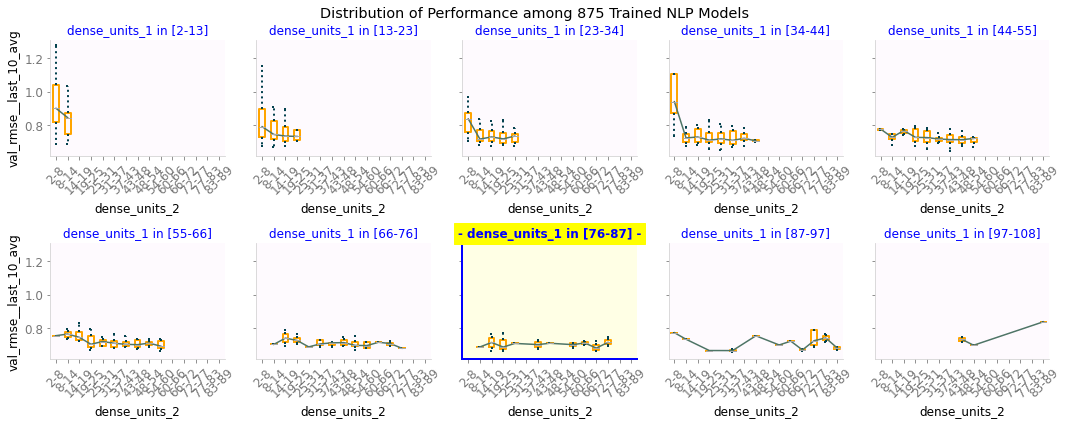

In [23]:
from my_NLP_RNN_fr_lib.model.plot import stratified_hyperparameter_rmse_boxplot

child_hyperparameter = absolute_performance_correlation.iloc[1].name # 'spatial_dropout_prop' # 

fig = stratified_hyperparameter_rmse_boxplot(
    trained_models_rndm_df
    , parent_hyperparameter = hyperparameter, parent_strats_count = 10, parent_strat_edge_format = "{0:0.0f}" # "{0:.2f}" # 
    , hyperparameter = child_hyperparameter, bins_count=15, bin_edge_format = "{0:0.0f}" # "{0:.3f}" # 
    , col_name = col_name
    , ncols = 5, figsize=(15, 6)
)
# allow space for 'fig.suptitle'
fig.tight_layout(rect=[0., 0., 1, 0.97]) # rect : tuple (left, bottom, right, top)
fig.suptitle('Distribution of Performance among ' +
             str(trained_models_rndm_df.shape[0]) + ' Trained NLP Models')
best_parent_strat_idx = lowest_median_idx - 1

best_strat_ax = fig.get_axes()[best_parent_strat_idx]
print("best_parent_strat : " + best_strat_ax.get_title())
best_strat_ax.set_title(
    label = "- " + best_strat_ax.get_title() + " -"
    , fontdict = {'fontsize':12, 'color':'blue', 'fontweight':'bold'}
    , backgroundcolor='yellow'
)
for ax_spine in ['left', 'top', 'right', 'bottom'] :
    best_strat_ax.spines[ax_spine].set_linewidth(2)
    best_strat_ax.spines[ax_spine].set_edgecolor('blue')
best_strat_ax.patch.set_facecolor('yellow')
best_strat_ax.patch.set_alpha(0.1)
plt.show()

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
The above figure is a representation of the variation of our NLP model performance with different values of '<b>{{child_hyperparameter}}</b>', stratified per bin of ''<b>{{hyperparameter}}</b>'. Those are respectively the second most and top most performance-correlated hyperparameters. We see that <u>correlation</u> (variance thresholds ; "filter" feature selection method) is not the primary criteria to be considered, since no clear pattern emerges.

To explain for the variance in our NLP model architecture performance, we need to turn toward <u>feature inmportance</u> (sequential feature selection ; "wrapper" feature selection method). Random forest and, even more so XGBoost algorithms are well suited high performers in that area.
</div>
</div>

<a name="xgboost"></a>
<h2>4. USING XGBOOST TO PREDICT THE PERFORMANCE OF AN NLP MODEL (BASED ON THE VALUES OF ITS HYPERPARAMETERS) <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
To predict, from a set of NLP hyperparameter values, what the performance of our NLP model architecture will be, we develop an NLP model performance XGBoost regressor.
<br />
<br />
As we will see here, building that XGBoost regressor will allow to uncover associations of hyperparameter values that dramatically improve our NLP model performance. It allows to gain a significant edge over the best set of hyperparameters that we could come up with via random search alone (the "random best" baseline).
</div>
</div>

<a name="optimization"></a>
<h3>4.1. XGBoost Regressor Optimization <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In [24]:
import xgboost as xgb, multiprocessing ; print("xgboost version " + str(xgb.__version__))

# XGBoost regressor training data
xgbR_X = trained_models_df.loc[:, ~trained_models_df.columns.isin([
    'timestamp', 'csv_idx', 'training records', 'validation records', 'is_random_set'
    , 'lr_decay_rate', 'lr_decay_step', 'batch_size', 'epochs', 'best_training_step', 'best_val_rmse', 'val_loss'
    , 'val_rmse__last_10_avg', 'val_loss__last_10_avg', 'train_rmse__last_10_avg', 'train_loss__last_10_avg'
    , 'local_path'])]
xgbR_y = trained_models_df['val_rmse__last_10_avg']
#print(str(xgbR_X.shape[0]) + " trained NLP models") # NOTE THAT WE NO LONGUER EXCLUDE XGBoost-IDENTIFIED SETS OF HYPERPARAMETERS (see "feedback loop" below)

xgboost version 1.1.1


In [25]:
from my_NLP_RNN_fr_lib.xgboost import xgbR_gridsearch_cv

# regressor
xgb_R = xgb.XGBRegressor(
    n_estimators=25000
    , max_depth=20
    , num_parallel_tree=2
    , learning_rate=0.05
    , reg_alpha=0.5 # L1 regularization term on weights, default=0
    , reg_lambda=0.5 # L2 regularization term on weights, default=1
    , verbosity=0
    , objective = 'reg:squarederror'
    , tree_method = 'exact' # recommended for small datasets
    #, tree_method = 'gpu_hist'
    , n_jobs=1
)
# gridsearch domain
xgbR_params_grid = {
    'learning_rate': [x*10**(-e) for e in range(3, 4) for x in [1, 5]],
    #'max_depth': [8, 10, 15, 20],
    'num_parallel_tree': [1, 4, 8],
    'subsample': [.3, .5, .7, 1.],
    'reg_alpha': [.001, .002, .005, .01],
    'reg_lambda': [.1, .4, .9, 5, 10]
}

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
We train our XGBoost regressor against {{"{:,}".format(np.prod([len(vals) for vals in xgbR_params_grid.values()]))}} different candidate configurations (using grid search and cross-validation via <span style="background-color: #e0e0e0">&nbsp;joblib.Parallel&nbsp;</span>).
Remember that our intent is to tune an XGBoost regressor so it predicts with the highest confidence which set of hyperparameter values would have our NLP model perform best&nbsp;:
</div>
</div>

In [87]:
xgbR_gridCv = xgbR_gridsearch_cv(
    xgb_R
    , xgbR_X, xgbR_y
    , params_grid = xgbR_params_grid
    , cv_folds_count = 3, test_size = .3
    , early_stopping_rounds = 2000
    , refit=True

    , n_jobs = multiprocessing.cpu_count()-1
    , par_backend = 'loky' # 'multiprocessing' # 'threading' # 

    , verbose = 2
)

Fitting 3 folds for each of 128 candidate xgboost configurations, totalling 384 fits


C:\Users\Organization\Anaconda3\envs\r-tensorflow\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



best_params_ : {'learning_rate': 0.005, 'reg_alpha': 0.001, 'reg_lambda': 5, 'subsample': 0.3}
refitting `best_estimator_` on the whole dataset.. done ; val_rmse = 0.124350.


<p style="font-family: monospace">Fitting 3 folds for each of 128 candidate xgboost configurations, totalling 384 fits
<div style="width: 510px;"><img alt="train models widgets" src="../../images/xgboost_grid_cv_widget.png?uncache=4648" /></div>
best_params_ : {'learning_rate': 0.005, 'reg_alpha': 0.001, 'reg_lambda': 5, 'subsample': 0.3}
<br />
refitting `best_estimator_` on the whole dataset.. done ; val_rmse = 0.124350.</p>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
Among the {{"{:,}".format(xgbR_gridCv.params_ranks_df.shape[0])}} candidate XGBoost configurations, we can for instance choose to visualize the best {{gridsearch_cv_visualize_restrict_rank = 4 ; "{:,}".format(gridsearch_cv_visualize_restrict_rank)}}. The below chart is a plot of the training history of these candidate XGBoost regressors. In dotted line, we have the candidate rmse measures on the validation datasets. The plain lines represent the measures on the training datasets. On the left column, we have plots for each of the {{max(xgbR_gridCv.evaluations_df['model_cv_fold'])+1}} individual CrossValidation folds (sometimes they overlap), whereas the right column displays means across folds (and associated shaded standard deviation bands, sometimes they are really thin)&nbsp;:
</div>
</div>

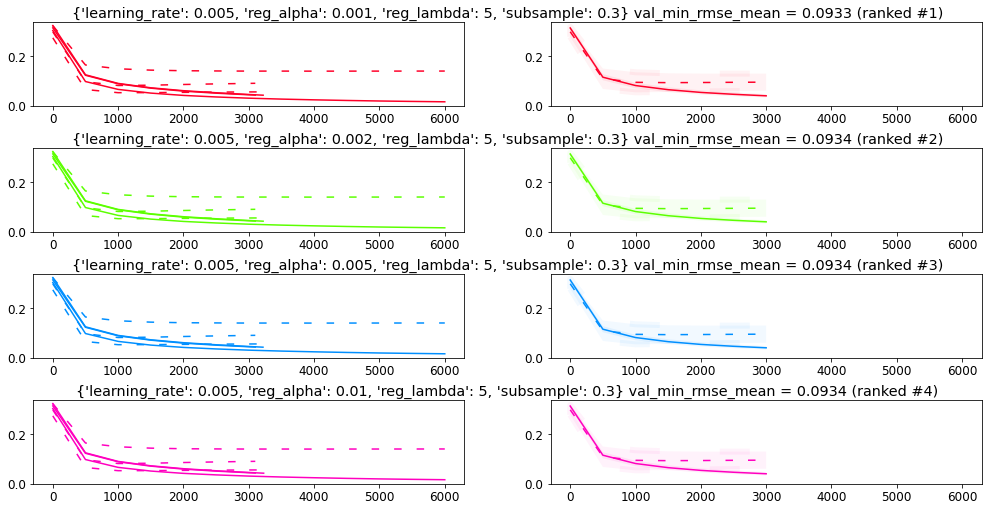

In [27]:
from my_NLP_RNN_fr_lib.xgboost import xgbR_gridsearch_cv_plot

fig = xgbR_gridsearch_cv_plot(xgbR_gridCv, params_subplots = True, restrict_rank = gridsearch_cv_visualize_restrict_rank
                              , include_train_rmse = True)
plt.show()

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
We hang on to the best-performing candidate XGBoost regressor and fit it on our entire collection of trained NLP model instances (on not on only a C.V. fold training subset anymore). The so-obtained XGBoost regressor of NLP hyperparameters model performance gives the below results&nbsp;:
</div>
</div>

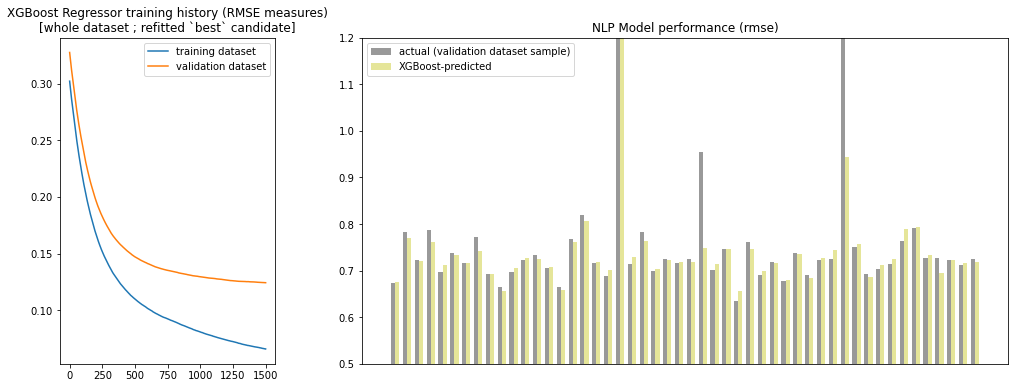

In [32]:
from matplotlib import gridspec
import random

fig = plt.figure(figsize=(17, 6)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# training history
ax0.plot(xgbR_gridCv.best_estimator_.evals_result()['validation_0']['rmse'], label="training dataset")
ax0.plot(xgbR_gridCv.best_estimator_.evals_result()['validation_1']['rmse'], label="validation dataset")
ax0.title.set_text("XGBoost Regressor training history (RMSE measures)\n[whole dataset ; refitted `best` candidate]")
ax0.legend()


# sampled prediction
sample_size = 50
sample_idx = random.sample(range(len(xgbR_y)), sample_size)
xgbR_y_pred = xgbR_gridCv.best_estimator_.predict(xgbR_X.loc[sample_idx])

x_index = np.arange(len(sample_idx))
bar_width = 0.35
ax1.bar(x_index, xgbR_y.loc[sample_idx], bar_width, label="actual (validation dataset sample)", color='black', alpha=.4)
ax1.bar(x_index + bar_width, xgbR_y_pred, bar_width, label="XGBoost-predicted", color='y', alpha=.4)
ax1.set_ylim(max(ax1.get_ylim()[0], .5), min(1.2, ax1.get_ylim()[1]))
ax1.set_title("NLP Model performance (rmse)")
ax1.legend()
ax1.get_xaxis().set_visible(False)
plt.show()

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
On the above figure, the left plot represents the training history of our refitted best performing XGBoost regressor candidate. The right plot is a representation of its predictive power for a sample of {{sample_size}} sets of NLP hyperparameter values and how well the corresponding NLP model instance performs.
</div>
</div>

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<a name="importance"></a>
<h3>4.2. NLP Model Hyperparameter Importance <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
The "feature importance" as XGBoost quantifies it is the summing up of how many times each feature is split on during trees construct.
</div>
</div>

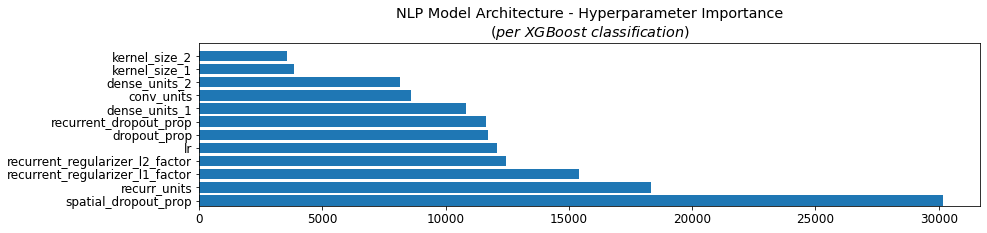

In [29]:
feature_important = xgbR_gridCv.best_estimator_.get_booster().get_score(importance_type='weight')
features_keys = list(feature_important.keys())
features_values = list(feature_important.values())

data = pd.DataFrame(data=features_values, index=features_keys, columns=["score"]) \
            .sort_values(by = "score", ascending=False)
fig = plt.figure(figsize=(14, 3)) ; ax = fig.gca()
y_index = np.arange(len(data)) ; width = .8
ax.barh(y_index, data.score, width)
ax.set(yticks=y_index, yticklabels=data.index, ylim=[2*(width-1), len(data)])
ax.set_title(label = 'NLP Model Architecture - Hyperparameter Importance\n' +
             r'$\it{(per}$ $\it{XGBoost}$ $\it{classification)}$')
plt.show()

In [30]:
features_indices = np.argsort(features_values)
ordered_features = [features_keys[i] for i in features_indices]

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
What we learn on the above figure is that, as per the findings of our XGBoost regressor, '<b>{{str(ordered_features[0])}}</b>' and '<b>{{str(ordered_features[1])}}</b> play a relatively little role in establishing the performance of our trained NLP models. '<b>{{str(ordered_features[len(features_indices)-2])}}</b>' and even more so '<b>{{str(ordered_features[len(features_indices)-1])}}</b>' on the other hand, have a decisive role in that performance. They account for most of the variability in the performance of our NLP model architecture.
</div>
</div>

In [31]:
trees_df = xgbR_gridCv.best_estimator_.get_booster().trees_to_dataframe()
tree_view_index = 999 # ordinal number of target tree to be visualized

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
An XGBoost model is a collection of weak predictors. Out of the {{"{:,}".format(max(trees_df['Tree']+1))}} trees of our XGBoost regressor (n_estimators = {{"{:,}".format(xgbR_gridCv.best_estimator_.n_estimators)}} ; num_parallel_tree = {{"{:,}".format(xgbR_gridCv.best_estimator_.num_parallel_tree if xgbR_gridCv.best_estimator_.num_parallel_tree else 1)}}), we can for instance visualize tree #{{tree_view_index+1}} below&nbsp;:
</div>
</div>

In [36]:
from IPython.core.display import display, HTML

# high resolution tree plot
gv_img = xgb.to_graphviz(xgbR_gridCv.best_estimator_, num_trees=tree_view_index, rankdir='LR')
fig_url = gv_img.render(os.path.join('..', '..', 'tmp', 'xgboost_tree'), format='png', cleanup=True)

# use base64 encoding to circumvent image (external file) caching (webbrowser)
with open(fig_url, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
encoded_string = "data:image/jpeg;charset=utf-8;base64, " + encoded_string.decode()

display(HTML('<a href="' + fig_url + '" target="_blank"><img src="' + encoded_string + '" style="width: 100%;"/></a>' +
             '<br /><center><em>click to enlarge</em></center>'))

In [32]:
tree_nodes_count_df = trees_df[(trees_df['Tree']==tree_view_index) & (trees_df['Feature']!='Leaf')] \
    .groupby(['Feature'], as_index=False)['Node'].count()

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
There are {{"{:,}".format(trees_df[trees_df['Feature']!='Leaf'].shape[0])}} tree nodes in total in our XGBoost regressor. Tree #{{tree_view_index+1}} counts {{tree_nodes_count_df['Node'].sum()}} of them and, among those, {{0 if len(tree_nodes_count_df[tree_nodes_count_df['Feature']==str(ordered_features[len(features_indices)-1])]['Node'])==0 else (tree_nodes_count_df[tree_nodes_count_df['Feature']==str(ordered_features[len(features_indices)-1])]['Node'].values[0])}} are branch splits based on the value of the most important NLP hyperparameter alone&nbsp;: '<b>{{str(ordered_features[len(features_indices)-1])}}</b>'.
</div>
</div>

<hr style="height: 4px; width: 70%; margin:0 auto;" />

backup

In [116]:
with open('xgbR_gridCv.pkl', 'wb') as output_file :
    pickle.dump(xgbR_gridCv, output_file)

reload

In [26]:
with open('xgbR_gridCv.pkl', 'rb') as input_file:
    xgbR_gridCv = pickle.load(input_file)

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<a name="supercharging"></a>
<h3>4.3. Supercharging the NLP model optimization using our XGBoost Regressor <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
We take our collection of NLP model trained instances gathered from the standard random search optimization performed so far and use it as a  bootstrap. With our NLP model performance XGBoost regressor now ready, we use it to accelerate our hyperparameters optimization.
<br />
<br />
Indeed, we can now throw tens of millions of sets of hyperparameters values to our xgboost regressor and, in a matter of minutes, in return, get a selection of the ones that are the most promissing in terms of NLP model performance.
Of course, xgboost doesn't tell us with high accuracy how good of a performance each of these few sets would lead to (since it can not predict something it had never seen before). It does however allow us to give a laser forcus on areas of interest.
This method brings us to uncover unsuspected levels of performance for our NLP model.
</div>
</div>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
Using the below custom method, we can identify a select few sets of hyperparameters for us to test when training our NLP model. That way, we can further optimize our NLP model and thus get a sharp enhancement compared to the best performance we got by using random search alone (the "random best" baseline).
</div>
</div>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
This process is computationnally greedy. We use <span style="background-color: #e0e0e0">&nbsp;Dask&nbsp;</span> to partition (and handle in parallel) the generation of sets of NLP hyperparameters and we use <em>vectorization</em> to evaluate (batches of) XGBoost predictions.
</div>
</div>

In [47]:
from my_NLP_RNN_fr_lib.model.supercharger import best_nlp_models_hyperparameters

xgbR_best_hyperparameters = best_nlp_models_hyperparameters(
    xgb_regressor = xgbR_gridCv.best_estimator_
    , best_models_count = 5
    , batch_models_count = 1_000_000
    , NLP_predicted_val_rmse_threshold = .63 # /* optional */
    , show_batch_box_plots = False
)

with open(os.path.join('..', 'xgbR_hyperparameters_pickle.pkl'), 'wb') as output_file :
    pickle.dump(xgbR_best_hyperparameters[:24].reset_index(drop=True)
                , output_file)

WAVE #1


get_new_hyperparameters - init : 18.0060 seconds
get_new_hyperparameters - Step II/II :
     100%|█████████████████████████████████████████████| 142/142 [06:54<00:00,  2.92s/it]
Generated 1,000,000 sets of hyperparameter values in 432.5120 seconds


Predict models performance :
     100%|█████████████████████████████████████████████| 20/20 [01:54<00:00,  5.70s/it]
Predicted performance of 1,000,000 NLP models  in 114.0254 seconds


Processed 1,000,000 new random sets of hyperparameter values with below distribution of predicted NLP models rmse :


5 new "best" hyperparameter values :


<!DOCTYPE html> 
 
 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 val_rmse (predicted) 
 
 
 0.68 
 99 
 0.03372 
 0.02567 
 0.00503 
 27 
 2 
 3 
 40 
 39 
 0.04 
 0.0379 
 0.631969 
 
 
 0.67 
 54 
 0.0379 
 0.007 
 0.01952 
 30 
 3 
 4 
 100 
 83 
 0.04 
 0.0339 
 0.631989 
 
 
 0.67 
 74 
 0.03816 
 0.0191 
 0.00573 
 31 
 2 
 4 
 104 
 100 
 0.12 
 0.0396 
 0.633495 
 
 
 0.59 
 103 
 0.01154 
 0.01534 
 0.00459 
 25 
 2 
 3 
 46 
 39 
 0.04 
 0.0394 
 0.634446 
 
 
 0.61 
 55 
 0.04394 
 0.01693 
 0.00262 
 27 
 3 
 4 
 43 
 33 
 0.03 
 0.0384 
 0.634871


WAVE #2


get_new_hyperparameters - init : 17.7542 seconds
get_new_hyperparameters - Step II/II :
     100%|█████████████████████████████████████████████| 142/142 [06:57<00:00,  2.94s/it]
Generated 1,000,000 sets of hyperparameter values in 435.5797 seconds


Predict models performance :
     100%|█████████████████████████████████████████████| 20/20 [01:55<00:00,  5.78s/it]
Predicted performance of 1,000,000 NLP models  in 115.5108 seconds


Processed 1,000,000 new random sets of hyperparameter values with below distribution of predicted NLP models rmse :


2 new "best" hyperparameter values :


<!DOCTYPE html> 
 
 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 val_rmse (predicted) 
 
 
 0.67 
 125 
 0.02942 
 0.02754 
 0.00969 
 31 
 4 
 2 
 102 
 66 
 0.04 
 0.0382 
 0.629635 
 
 
 0.68 
 99 
 0.03372 
 0.02567 
 0.00503 
 27 
 2 
 3 
 40 
 39 
 0.04 
 0.0379 
 0.631969 
 
 
 0.67 
 54 
 0.0379 
 0.007 
 0.01952 
 30 
 3 
 4 
 100 
 83 
 0.04 
 0.0339 
 0.631989 
 
 
 0.67 
 74 
 0.03816 
 0.0191 
 0.00573 
 31 
 2 
 4 
 104 
 100 
 0.12 
 0.0396 
 0.633495 
 
 
 0.68 
 108 
 0.02964 
 0.01023 
 0.00556 
 29 
 2 
 2 
 83 
 60 
 0.03 
 0.0346 
 0.633893


WAVE #3


get_new_hyperparameters - init : 17.5399 seconds
get_new_hyperparameters - Step II/II :
      33%|██████████████▉                              | 47/142 [02:23<04:50,  3.05s/it] 


 Interrupted by user ! 
As per the prediction of the XGBoost regressor, out of the 2,000,000 random sets of hyperparameters considered, here are the final 5 predicted "best" :


<!DOCTYPE html> 
 
 
 
 
 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 val_rmse (predicted) 
 
 
 
 
 0.67 
 125 
 0.02942 
 0.02754 
 0.00969 
 31 
 4 
 2 
 102 
 66 
 0.04 
 0.0382 
 0.629635 
 
 
 0.68 
 99 
 0.03372 
 0.02567 
 0.00503 
 27 
 2 
 3 
 40 
 39 
 0.04 
 0.0379 
 0.631969 
 
 
 0.67 
 54 
 0.03790 
 0.00700 
 0.01952 
 30 
 3 
 4 
 100 
 83 
 0.04 
 0.0339 
 0.631989 
 
 
 0.67 
 74 
 0.03816 
 0.01910 
 0.00573 
 31 
 2 
 4 
 104 
 100 
 0.12 
 0.0396 
 0.633495 
 
 
 0.68 
 108 
 0.02964 
 0.01023 
 0.00556 
 29 
 2 
 2 
 83 
 60 
 0.03 
 0.0346 
 0.633893

<hr style="height: 4px; width: 70%; margin:0 auto;" />

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
This methodology makes it possible to further "specialize" our XGBoost regressor into a "best performing NLP model" predictor.
<br />
<br />
By being highly selective in identifying promissing sets of hyperparameters, then actually training NLP models using those sets and measuring the actual performance of these NLP models, and by finally feeding these new data points as additional training material for our XGBoost regressor, the regressor indeed increases his predictive power in this highly specialized area of "best performing NLP models".
<br />
<br />
This becomes a virtuous cycle which proves to be very effective.
<br />
<br />
In laymans terms : when, at a point in time, our XGBoost regressor thinks a given set of NLP hyperparameters will perform "$\hat{y}$" and we tell him it actualy performs "y", it then adjusts its inner workings for the next round.
<br />
<br />
This is the procedure described in the below process chart&nbsp;:
</div>
</div>

<center>
<b>NLP hyperparameters random search on (XGBoost) stero&iuml;ds</b>
<a href="..\..\images\hyperparameters.png" target="_blank"><img src="..\..\images\hyperparameters.png" style="width: 100%;"/></a>
<em><small>click to enlarge</small></em>
</center>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
After only a couple of "specializing" feedback loops, we obtain a dramatic gain of performance for our NLP model as compared to what the usual random search had allowed after several hundred attempts (the "random best" baseline). This can be observed on the below updated scatter plot. <b><span style="background-color: #00FFFF;">&nbsp;We're now able to identify an optimized, highly-performing, set of hyperparameter values for our French NLP text classification model&nbsp;!&nbsp;</span></b>
</div>
</div>

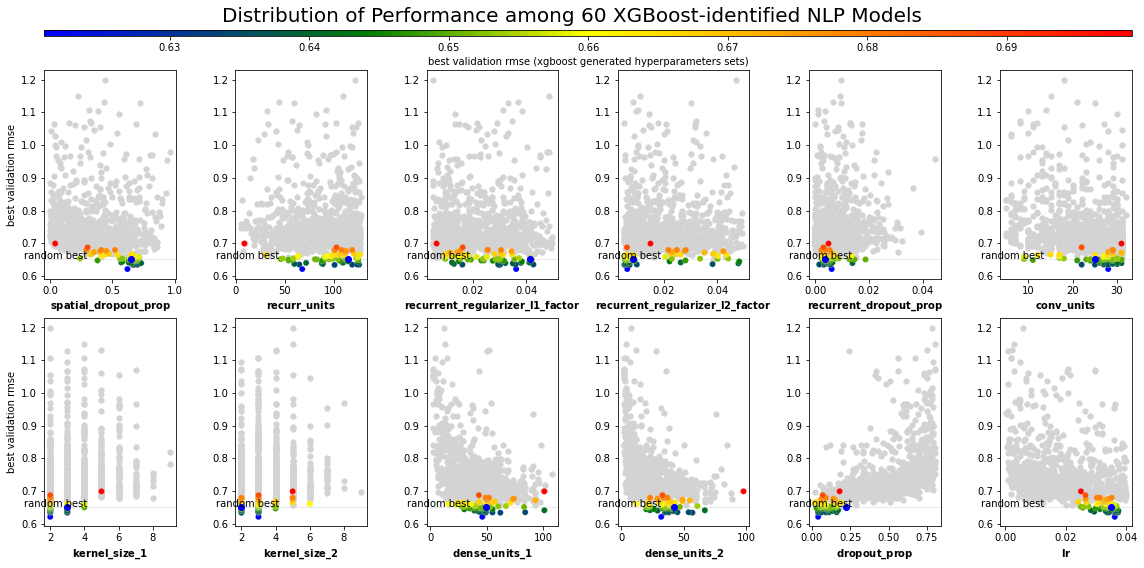

In [81]:
from my_NLP_RNN_fr_lib.model.plot import hyperparameters_univariate_rmse_overlay_plot

xgboost_identified_nlp_models_fig = \
    hyperparameters_univariate_rmse_overlay_plot(
        hyperparameters_univariate_rmse_fig
        , trained_models_df[trained_models_df[ "is_random_set" ] == False]
        , col_name = 'val_rmse__last_10_avg'
    )

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
For information, the #1 best performing (XGBoost-identified) set of NLP hyperparameter values is the following&nbsp;:
</div>
</div>

In [82]:
format_vertical_headers(
    trained_models_df.iloc[[
        trained_models_df[(trained_models_df['lr_decay_rate']==.1) &
                          (trained_models_df['lr_decay_step']==45)
                         ]['val_rmse__last_10_avg'].idxmin()
    ]].drop(['csv_idx', 'timestamp', 'is_random_set', 'training records', 'validation records'
             , 'best_val_rmse', 'val_loss', 'best_training_step', 'local_path'], axis=1)
    , greyed_out_colnames = ['lr_decay_rate', 'lr_decay_step', 'batch_size', 'epochs',
                             'val_rmse__last_10_avg', 'val_loss__last_10_avg'
                              , 'train_rmse__last_10_avg', 'train_loss__last_10_avg' ])

<!DOCTYPE html> 
 
 
 
 
 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 lr_decay_rate 
 lr_decay_step 
 batch_size 
 epochs 
 val_rmse__last_10_avg 
 val_loss__last_10_avg 
 train_rmse__last_10_avg 
 train_loss__last_10_avg 
 
 
 
 
 0.67 
 101 
 0.02979 
 0.00724 
 0.00572 
 28 
 3 
 2 
 62 
 57 
 0.04 
 0.0363 
 0.1 
 45 
 512 
 120 
 0.633598 
 1.414889 
 0.475392 
 1.032591

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
NOTE&nbsp;: As seen <b><a href="#reviews">&sect;1.2.</a></b> , the whole NLP hyperparameter optimization process has been performed on a subset of our training data. A significant absolute increase in model performance is thus to be expected when the optimum hyperparameters configuration is used on the whole training dataset. RMSE measures here are just a relative order of magnitude that we used to compare model instances and rank them.
</div>
</div>

<a name="conclusion"></a>
<h2>5. CONCLUSION <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style='background-color: rgba(0, 255, 255, 0.04); border: 1px solid rgba(0, 255, 255, .2);'>
<div style='text-align: justify; margin-left: 5px; margin-right: 5px;'>
In the herein notebook, we optimized the hyperparameter values to be used in conjunction with the architecture of the <span style="background-color: #e0e0e0">&nbsp;Tensorflow&nbsp;</span>/<span style="background-color: #e0e0e0">&nbsp;Keras&nbsp;</span> French NLP model developped in <a href="https://github.com/aurelienmorgan/french_text_sentiment/">this parent notebook</a>.
<br />
<br />
We started by training a collection of model instances using standard random search (@see <b><a href="#search">&sect;2.</a></b>&nbsp;). In a second time, we explored the resulting dataset consisting of a set of hyperparameter values on one hand and of corresponding NLP model performance measures on the other. We did that to investiguate whether relations between the two could be clearly identified (@see <b><a href="#analysis">&sect;3.</a></b>&nbsp;). Then we turned towards the <span style="background-color: #e0e0e0">&nbsp;XGBoost&nbsp;</span>/<span style="background-color: #e0e0e0">&nbsp;ScikitLearn&nbsp;</span> librairies to help us navigate the high-dimension space of hyperparameters in order to reach optimum configuration for our NLP model (@see <b><a href="#xgboost">&sect;4.</a></b>&nbsp;).
<br />
<br />
For classical machine learning problems or any problem of relatively manageable complexity, GridSearch can serve as an optimization procedure well. When the space dimensionality increases as it is the case of our NLP model with the many hyperparameters to be tuned together, random search becomes almost inevitable, since the domain of possible values permutations becomes gigantic.
<br />
There are libraries out there that relate to techniques such as <u>Bayesian Hyperparameter Optimization for Machine Learning</u> to take care of enhancing the efficiency of the random search procedure, still mostly applied to standard machine learning. In the context of <b>Deep Learning model optimization</b>, we thought of using XGBoost. However relatively tedious, the process proved to provide tangible gains in our NLP model performance.
</div>
</div>

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

&nbsp;

# EXTRA

<b>Export Notebook to HTML (with Markdown extension cells evaluated)</b>

In [34]:
from my_NLP_RNN_fr_lib.jupyter_markdown_extension import md_extension_to_html

md_extension_to_html(os.path.join(os.path.realpath('.'), 'hyperparameters_values_search.ipynb'))
md_extension_to_html(os.path.realpath(os.path.join('..', '..', 'data', 'fastText_french', 'cc.fr.300.light.vec.ipynb')))

'hyperparameters_values_search.ipynb' ; 'D:\jupyter_notebooks\NLP_Sentiment_Analysis_French\model\optimization\hyperparameters_values_search.html'
done.
'cc.fr.300.light.vec.ipynb' ; 'D:\jupyter_notebooks\NLP_Sentiment_Analysis_French\data\fastText_french\cc.fr.300.light.vec.html'
done.


<hr style="height: 4px; width: 70%; margin:0 auto;" />

<b>Manually re-train models using given sets of hyperparameters values&nbsp:</b>

In [47]:
tmp_df01 = pd.DataFrame(
    [[1, 0.71, 90, 0.02722, 0.04377, 0.00183, 28, 3, 2, 2, 2, 0.12, 0.0278, 0.2, 49]]
)
tmp_df01.columns = hyperparameters.columns
tmp_df02 = pd.DataFrame(
    [[1, 0.55, 110, 0.01564, 0.02171, 0.03221, 28, 5, 2, 31, 5, 0.45, 0.0235, 0.46, 17]]
)
tmp_df02.columns = hyperparameters.columns

hyperparameters = pd.concat([tmp_df01, tmp_df02], ignore_index=True)
format_vertical_headers(
    hyperparameters
    .reset_index(level=0).rename(columns = {'index':'trained model'})
)

<!DOCTYPE html> 
 
 
 
 
 
 trained model 
 is_random_set 
 spatial_dropout_prop 
 recurr_units 
 recurrent_regularizer_l1_factor 
 recurrent_regularizer_l2_factor 
 recurrent_dropout_prop 
 conv_units 
 kernel_size_1 
 kernel_size_2 
 dense_units_1 
 dense_units_2 
 dropout_prop 
 lr 
 lr_decay_rate 
 lr_decay_step 
 
 
 
 
 0 
 1 
 0.71 
 90 
 0.02722 
 0.04377 
 0.00183 
 28 
 3 
 2 
 2 
 2 
 0.12 
 0.0278 
 0.20 
 49 
 
 
 1 
 1 
 0.55 
 110 
 0.01564 
 0.02171 
 0.03221 
 28 
 5 
 2 
 31 
 5 
 0.45 
 0.0235 
 0.46 
 17

<hr style="height: 4px; width: 70%; margin:0 auto;" />